## MBP1413 AI Project

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA


# Data Processing
This is a dataset containing clinicopathological features of diabetes patients, and whether they were readmitted to hospital. The dataset has  been processed to exclude any patients or variables containing several unknown or NA values. Other variables showing a very high proportion of a single value for a variable has also been removed to reduce risk of background noise and potential of overfitting. Low cardinal variables, including gender and race, were transformed by one-hot encoding to allow correct feature preparation to train a machine learning model. Other high cardinal variables, such as diagnoses and admission types, were transformed by target-encoding into numerical representations calculated by the target variable, which allows to capture informative variation within features for model training. 

In [2]:
#loading dataset needed for predictions
diabetes_data = pd.read_csv("diabetic_data.csv")
print(diabetes_data)

        encounter_id  patient_nbr       race           gender       age  \
0            2309268     77475465  Caucasian           Female   [80-90)   
1            2311404     95586993  Caucasian           Female  [90-100)   
2            2548314     48452823  Caucasian           Female   [60-70)   
3            2660244     80156115  Caucasian           Female   [70-80)   
4            2926554     86209290  Caucasian           Female   [70-80)   
...              ...          ...        ...              ...       ...   
101761     423217946     46640079  Caucasian             Male   [70-80)   
101762     432547058     50579514   Hispanic             Male   [60-70)   
101763      98634858    100695042      Other  Unknown/Invalid   [70-80)   
101764     226864668     60524946          ?  Unknown/Invalid   [60-70)   
101765     257364294     78119847          ?  Unknown/Invalid   [70-80)   

       weight  admission_type_id  discharge_disposition_id  \
0           ?                  6     

/var/folders/tv/k6gxf_7n3pz6nwp4w7tth3k40000gn/T/ipykernel_18041/2096091387.py:2: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  diabetes_data = pd.read_csv("diabetic_data.csv")


In [3]:
#Exploring dimensions, columns, and the category of each of the data columns
print("The dimensions of the dataset are:", diabetes_data.shape)
print("Total number of columns in the dataset:", len(diabetes_data.columns))
print(diabetes_data.info(verbose=True))


The dimensions of the dataset are: (101766, 50)
Total number of columns in the dataset: 50
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures     

## Identifying missing values in the dataset
We have investigated missing values within the dataset, and have chosen to remove several predictor variables containing many missing values. 

In [4]:
missing_value_counts = diabetes_data.apply(lambda col: col.astype(str).str.count(r'\?').sum())
print(missing_value_counts.to_string())

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [5]:
#identifying number of missing values for columns that have any missing values
for col in diabetes_data.columns:
    missing_value = diabetes_data.loc[diabetes_data[col] == '?', col].value_counts()
    if len(missing_value.values > 0):
        print("Percentage of missing values in", col," - ", missing_value.values/len(diabetes_data)*100)

Percentage of missing values in race  -  [2.23355541]
Percentage of missing values in weight  -  [96.85847926]
Percentage of missing values in payer_code  -  [39.55741603]
Percentage of missing values in medical_specialty  -  [49.0822082]
Percentage of missing values in diag_1  -  [0.02063558]
Percentage of missing values in diag_2  -  [0.35178743]
Percentage of missing values in diag_3  -  [1.39830592]


In [6]:
#dropping columns of weight, payer_code and medical_specialty as they have too many missing values
diabetes_data = diabetes_data.drop(columns = ["weight", "payer_code", "medical_specialty"])

In [7]:
#dropping patients with missing values that remain in the dataset
diabetes_data = diabetes_data[~diabetes_data.isin(['?']).any(axis=1)]

In [8]:
#removing encounter_id and patient_nbr
diabetes_data.drop(["encounter_id", "patient_nbr"], axis=1, inplace=True)

In [9]:
#Identifying columns containing values where measurements were not taken for specific tests. A1Cresult and max_glu_serum have high proportions where result was not measured.
#These will thus be removed from the analysis.
diabetes_data['A1Cresult'] = diabetes_data['A1Cresult']\
    .replace({'>7': 1, '>8': 1, 'Norm': 0, None: -99})\
    .fillna(0)

diabetes_data['max_glu_serum'] = diabetes_data['max_glu_serum']\
    .replace({'>200': 1, '>300': 1, 'Norm': 0, None: -99})\
    .fillna(0)

/var/folders/tv/k6gxf_7n3pz6nwp4w7tth3k40000gn/T/ipykernel_18041/3669577407.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'>7': 1, '>8': 1, 'Norm': 0, None: -99})\
/var/folders/tv/k6gxf_7n3pz6nwp4w7tth3k40000gn/T/ipykernel_18041/3669577407.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'>200': 1, '>300': 1, 'Norm': 0, None: -99})\


In [10]:
#for 24 medications, convert all nones to 0, and all other values to 1
medicines = ['metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
       'glipizide-metformin', 'glimepiride-pioglitazone',
       'metformin-rosiglitazone', 'metformin-pioglitazone']

for col in medicines:
    diabetes_data[col] = diabetes_data[col].apply(lambda x: 0 if x == 'No' else 1)


In [11]:
#looking at number of times medication is not used to only select medications that are featured extensively
percentage_not_taken = diabetes_data[medicines].apply(lambda col: (col.astype(int) == 0).sum())/68630*100
print(percentage_not_taken)


metformin                   114.830249
repaglinide                 140.652776
nateglinide                 141.865074
chlorpropamide              142.750984
glimepiride                 135.605420
acetohexamide               142.870465
glipizide                   124.973044
glyburide                   127.920734
tolbutamide                 142.839866
pioglitazone                132.529506
rosiglitazone               133.887513
acarbose                    142.436252
miglitol                    142.818010
troglitazone                142.867551
tolazamide                  142.818010
examide                     142.871922
citoglipton                 142.871922
insulin                      66.943028
glyburide-metformin         141.897130
glipizide-metformin         142.852980
glimepiride-pioglitazone    142.870465
metformin-rosiglitazone     142.871922
metformin-pioglitazone      142.870465
dtype: float64


In [12]:
#removing medications that percentage not taken at least 95%
medicines_to_remove = percentage_not_taken[percentage_not_taken > 95].index
print("Medication to be removed:", medicines_to_remove)
diabetes_data = diabetes_data.drop(columns=medicines_to_remove)

df_exploring = diabetes_data




Medication to be removed: Index(['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'glyburide-metformin',
       'glipizide-metformin', 'glimepiride-pioglitazone',
       'metformin-rosiglitazone', 'metformin-pioglitazone'],
      dtype='object')


In [13]:
#converting change into values of 0 and 1 - indicating no change in medication or change in medication
#also converting values of diabetes medications from no and yes into 0 and 1 respectively
diabetes_data["change"] = diabetes_data["change"].apply(lambda x: 0 if x == 'no change' else 1)
diabetes_data["diabetesMed"] = diabetes_data["diabetesMed"].apply(lambda x: 0 if x == 'No' else 1)

In [14]:
#converting age into the average of each of the age ranges
diabetes_data['age'].replace({'[0-10)': 5, '[10-20)': 15, '[20-30)': 25,
                             '[30-40)': 35, '[40-50)': 45, '[50-60)': 55,
                             '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95,
                            }, inplace=True)
diabetes_data.rename(columns = {"age": "Average Age"}, inplace=True)

/var/folders/tv/k6gxf_7n3pz6nwp4w7tth3k40000gn/T/ipykernel_18041/3527412211.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  diabetes_data['age'].replace({'[0-10)': 5, '[10-20)': 15, '[20-30)': 25,
/var/folders/tv/k6gxf_7n3pz6nwp4w7tth3k40000gn/T/ipykernel_18041/3527412211.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_s

In [15]:
#performing one-hot encoding on the low cardinality variables - 0 indicating no and 1 indicating yes that they belong in that population
low_cardinality = ["race", "gender"]
one_hot_encoded = pd.get_dummies(diabetes_data[low_cardinality]).astype(int)
diabetes_data = pd.concat([diabetes_data, one_hot_encoded], axis=1)
diabetes_data = diabetes_data.drop(columns=["race", "gender"])



In [16]:
#converting target variable from No and >30 into 0 and <30 into 1
diabetes_data["readmitted"].replace({"NO": 0,
                                     ">30": 0,
                                    "<30": 1}, inplace=True)

diabetes_data_nn = diabetes_data
diabetes_data_nn.to_csv("nn_diabetes_data.csv")

/var/folders/tv/k6gxf_7n3pz6nwp4w7tth3k40000gn/T/ipykernel_18041/1805196288.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  diabetes_data["readmitted"].replace({"NO": 0,
/var/folders/tv/k6gxf_7n3pz6nwp4w7tth3k40000gn/T/ipykernel_18041/1805196288.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [17]:
#performing one-hot encoding on high cardinality variables - also applying smoothing to reduce risk of overfitting
diabetes_data = diabetes_data.drop(columns = ['diag_2', 'diag_3', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id'])

diag_list = ['diag_1']

for col in diag_list:
    diabetes_data[col].fillna('NaN', inplace=True)

import re
def transformFunc(value):
    value = re.sub("V[0-9]*", "0", value) # V 
    value = re.sub("E[0-9]*", "0", value) # E 
    value = re.sub('NaN', "-1", value) # Nan 
    return value

def transformCategory(value):
    if value>=390 and value<=459 or value==785:
        category = 'Circulatory'
    elif value>=460 and value<=519 or value==786:
        category = 'Respiratory'
    elif value>=520 and value<=579 or value==787:
        category = 'Digestive'
    elif value==250:
        category = 'Diabetes'
    elif value>=800 and value<=999:
        category = 'Injury'          
    elif value>=710 and value<=739:
        category = 'Musculoskeletal'   
    elif value>=580 and value<=629 or value==788:
        category = 'Genitourinary'
    elif value>=140 and value<=239 :
        category = 'Neoplasms'
    elif value==-1:
        category = 'NAN'
    else :
        category = 'Other'

    return category

for col in diag_list:
    diabetes_data[col] = diabetes_data[col].apply(transformFunc)
    diabetes_data[col] = diabetes_data[col].astype(float)

for col in diag_list:
    diabetes_data[col] = diabetes_data[col].apply(transformCategory)



/var/folders/tv/k6gxf_7n3pz6nwp4w7tth3k40000gn/T/ipykernel_18041/3444689197.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  diabetes_data[col].fillna('NaN', inplace=True)


In [18]:
one_hot_encoded_diag = pd.get_dummies(diabetes_data['diag_1']).astype(int)
diabetes_data = pd.concat([diabetes_data, one_hot_encoded_diag], axis=1)
diabetes_data = diabetes_data.drop(columns=["diag_1"])

In [19]:
diabetes_data = diabetes_data.drop(columns = "gender_Unknown/Invalid")

In [20]:
#changing the order of columns on the dataset to move lower cardinal categories to the front, and the target variable to the end

#dropping change as it only has 1 value count
diabetes_data = diabetes_data.drop(columns = "change")

diabetes_data.to_csv("processed_data.csv")

# Dataset Exploration
Having completed pre-processeding, code implemented for data exploration is shown below. In general, this shows the variation of features identified across different predictor variables, and the relative distribution of the readmission of patients in relation to each of the predictors. 

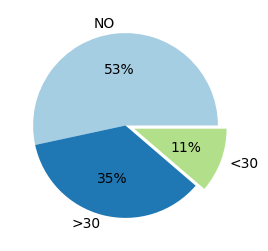

In [21]:
#Distribution of readmission of patients in this study
readmission_counts = df_exploring['readmitted'].value_counts()
explode = [0,0,0.1]
palette_color = sns.color_palette('Paired')
plt.figure(figsize=(4, 3))
plt.pie(readmission_counts, colors=palette_color, labels = readmission_counts.index, explode=explode, autopct='%.0f%%')
plt.savefig("pie.png", dpi = 300)
            


/var/folders/tv/k6gxf_7n3pz6nwp4w7tth3k40000gn/T/ipykernel_18041/468817513.py:4: UserWarning: The palette list has more values (12) than needed (3), which may not be intended.
  sns.countplot(x="race", hue="readmitted", data=df_exploring, hue_order=hue_order, palette=palette_color)


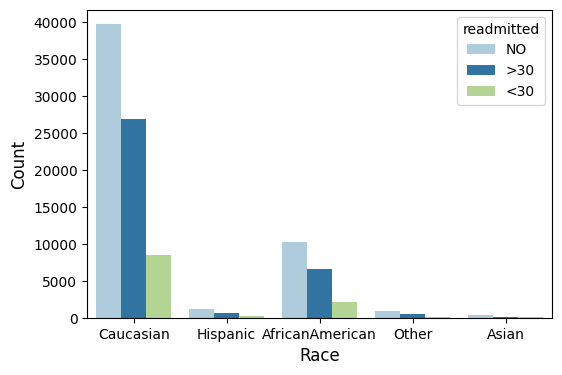

In [23]:
#Readmission status based on race
hue_order = ['NO', '>30', '<30']
plt.figure(figsize=(6, 4))
sns.countplot(x="race", hue="readmitted", data=df_exploring, hue_order=hue_order, palette=palette_color)
plt.xlabel("Race", size = 12)
plt.ylabel("Count", size = 12)
plt.savefig("race.png", dpi = 300)


/var/folders/tv/k6gxf_7n3pz6nwp4w7tth3k40000gn/T/ipykernel_18041/2914339354.py:5: UserWarning: The palette list has more values (12) than needed (3), which may not be intended.
  ax = sns.countplot(x="gender", hue="readmitted", data=df_exploring, palette=palette_color, hue_order=hue_order)


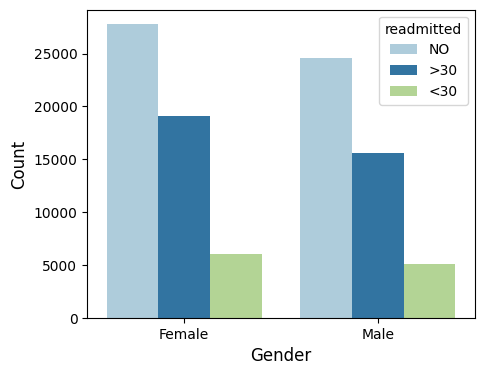

In [24]:
#Gender distribution of patients
df_exploring = df_exploring[df_exploring["gender"].isin(["Male", "Female"])]
hue_order = ['NO', '>30', '<30']
plt.figure(figsize=(5, 4))
ax = sns.countplot(x="gender", hue="readmitted", data=df_exploring, palette=palette_color, hue_order=hue_order)
plt.xlabel("Gender", size = 12)
plt.ylabel("Count", size = 12)
plt.savefig("gender.png", dpi=300)

/var/folders/tv/k6gxf_7n3pz6nwp4w7tth3k40000gn/T/ipykernel_18041/3869789228.py:5: UserWarning: The palette list has more values (12) than needed (3), which may not be intended.
  ax = sns.countplot(x="Average Age", hue="readmitted", data=df_exploring, palette=palette_color, hue_order=hue_order)


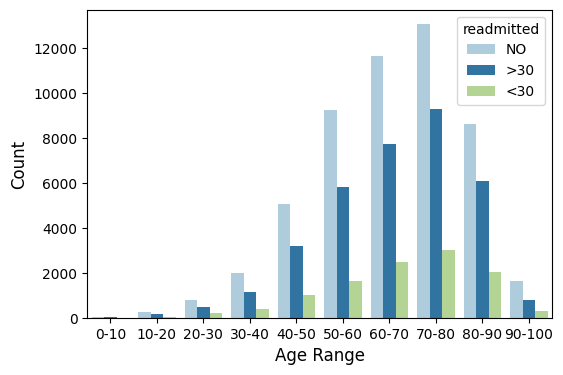

In [25]:
#distribution of readmission status based on age
hue_order = ['NO', '>30', '<30']
new_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
plt.figure(figsize=(6, 4))
ax = sns.countplot(x="Average Age", hue="readmitted", data=df_exploring, palette=palette_color, hue_order=hue_order)
plt.xticks(ticks=range(len(new_labels)), labels=new_labels)
plt.xlabel("Age Range", size = 12)
plt.ylabel("Count", size = 12)
plt.savefig("age.png", dpi=300)


/var/folders/tv/k6gxf_7n3pz6nwp4w7tth3k40000gn/T/ipykernel_18041/237630204.py:4: UserWarning: The palette list has more values (12) than needed (3), which may not be intended.
  ax = sns.countplot(x="time_in_hospital", hue="readmitted", data=df_exploring, palette=palette_color, hue_order=hue_order)


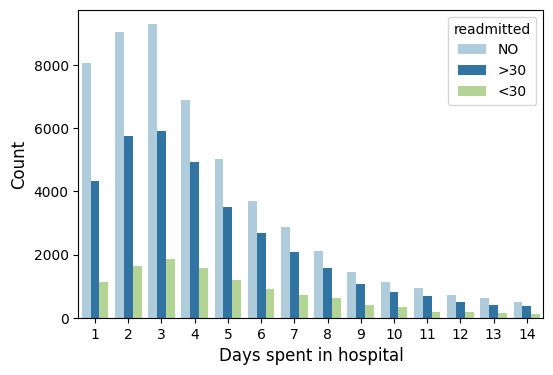

In [26]:
#assessing whether time spent at hospital has any indication for readmission
hue_order = ['NO', '>30', '<30']
plt.figure(figsize=(6, 4))
ax = sns.countplot(x="time_in_hospital", hue="readmitted", data=df_exploring, palette=palette_color, hue_order=hue_order)
plt.xlabel("Days spent in hospital", size = 12)
plt.ylabel("Count", size = 12)
plt.savefig("time.png", dpi=300)

/var/folders/tv/k6gxf_7n3pz6nwp4w7tth3k40000gn/T/ipykernel_18041/1886293610.py:4: UserWarning: The palette list has more values (12) than needed (3), which may not be intended.
  ax = sns.displot(df_exploring, x = "num_medications", hue = "readmitted", kind = "kde", hue_order=hue_order, palette=palette_color)


<Figure size 600x400 with 0 Axes>

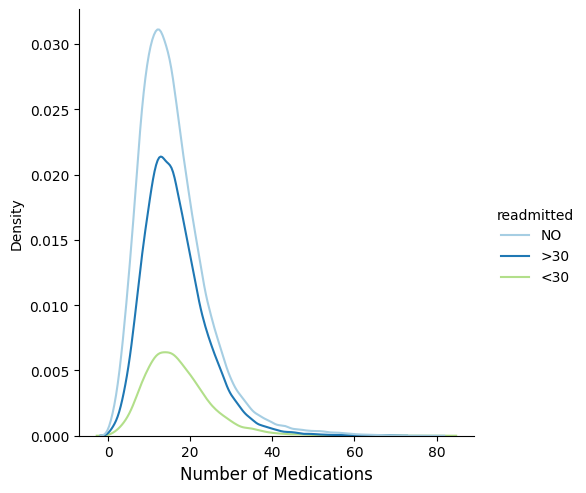

In [27]:
#assessing number of medications vs readmission
hue_order = ['NO', '>30', '<30']
plt.figure(figsize=(6, 4))
ax = sns.displot(df_exploring, x = "num_medications", hue = "readmitted", kind = "kde", hue_order=hue_order, palette=palette_color)
plt.xlabel("Number of Medications", size = 12)
plt.savefig("density.png", dpi=300)


/var/folders/tv/k6gxf_7n3pz6nwp4w7tth3k40000gn/T/ipykernel_18041/1284545416.py:5: UserWarning: The palette list has more values (12) than needed (3), which may not be intended.
  ax = sns.countplot(df_exploring, x = "diabetesMed", hue = "readmitted", hue_order=hue_order, palette=palette_color)


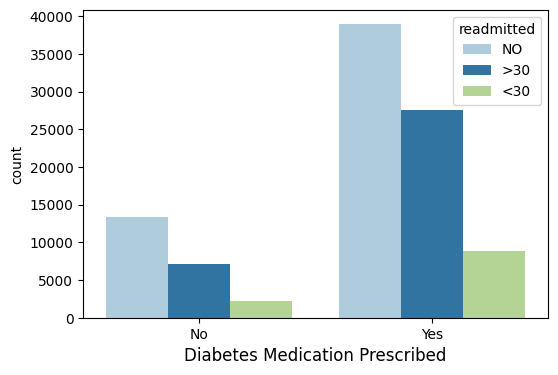

In [28]:
#number of diabetes medication administered vs readmission status
hue_order = ['NO', '>30', '<30']
diabetes_med_label = ['No', 'Yes']
plt.figure(figsize=(6, 4))
ax = sns.countplot(df_exploring, x = "diabetesMed", hue = "readmitted", hue_order=hue_order, palette=palette_color)
plt.xticks(ticks=range(len(diabetes_med_label)), labels=diabetes_med_label)
plt.xlabel("Diabetes Medication Prescribed", size = 12)
plt.savefig("meds.png", dpi=300)